# Multilabel Classification with TF-IDF and Naive Bayes

This notebook demonstrates a multilabel text classification task using TF-IDF for feature extraction and Naive Bayes for classification. The dataset used is a CSV file with descriptions and tags.


## Libraries and Dependencies

In [32]:
import pandas as pd
import copy
import torch
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score,accuracy_score, classification_report, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score

## Loading the Data
Read the CSV file containing the data.

In [33]:
df=pd.read_csv('en_CTP10_tokenized.csv')
df.head()

,Unnamed: 0,time_limit,memory_limit,description,tags,language,tokenized_description
0,1616/E,1.0,256.0,give two string $$$ s $$$ $$$ t $$$ equal leng...,"['bruteforce', 'datastructures', 'greedy', 'st...",en,"[0, 26650, 80, 6755, 68, 42654, 579, 68, 42654..."
1,900/A,1.0,256.0,n distinct point a plane none lie oy axis chec...,"['geometry', 'implementation']",en,"[0, 282, 11693, 477, 10, 3286, 4146, 6105, 231..."
2,702/F,4.0,1024.0,big consignment t - shirts go sale shop begin ...,['datastructures'],en,"[0, 8527, 7407, 15645, 326, 111, 15331, 213, 1..."
3,181/A,2.0,256.0,berland capital shake three bold crimes commit...,"['bruteforce', 'geometry', 'implementation']",en,"[0, 1943, 1245, 812, 8559, 130, 7457, 3474, 62..."
4,1352/A,1.0,256.0,a positive ( strictly greater zero ) integer c...,"['implementation', 'math']",en,"[0, 102, 1313, 36, 14657, 2388, 4276, 4839, 48..."


## TF-IDF Vectorization
Use `TfidfVectorizer` to convert the text descriptions into numerical features.

In [34]:
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['description'])
X.shape

(1624, 1000)

## Preprocessing the Tags
Convert the `tags` column from strings to lists.

In [35]:
import ast

tags = df['tags'].tolist()
for i in range(len(tags)):
    tags[i] = str(tags[i])

df['tags'] = [ast.literal_eval(tag) for tag in tags]

## Binarizing the Tags
Use `MultiLabelBinarizer` to convert the tags into a binary format.

In [36]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['tags'])

## Train-Test Split
Split the data into training and testing sets.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Training
Train a `MultinomialNB` classifier using `OneVsRestClassifier`.

In [38]:
nb= MultinomialNB()

classifier = OneVsRestClassifier(nb)
classifier.fit(X_train, y_train)

X_train.shape

(1299, 1000)

## Predictions
Make predictions on the test set.

In [79]:
y_pred = classifier.predict(X_test)
y_pred.shape

(325, 10)

Ensure that each text has at least one tag predicted.

In [80]:
y_pred1=copy.copy(y_pred)

for i in range(y_pred1.shape[0]):
    if not y_pred1[i].any():
        # Assign the most probable tag
        y_pred1[i, np.argmax(classifier.predict_proba(X_test[i]))] = 1

## Evaluation
Evaluate the model using various metrics.

In [81]:
#F1 Score (Macro)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
f11 = f1_score(y_test, y_pred1, average='macro', zero_division=0)
print(f'F1 Score: {f1}')
print(f'F1 Score (Al menos un tag por problema): {f11}')

F1 Score: 0.16300395146414276
F1 Score (Al menos un tag por problema): 0.23954524090405585


In [82]:
# Calcular el roc_auc_score con promedio macro
roc_auc = roc_auc_score(y_test, y_pred, average='macro', multi_class='ovr')
roc_auc1 = roc_auc_score(y_test, y_pred1, average='macro', multi_class='ovr')
print(f'ROC AUC Score: {roc_auc}')
print(f'ROC AUC Score (Al menos un tag por problema): {roc_auc1}')

ROC AUC Score: 0.5411140555341041
ROC AUC Score (Al menos un tag por problema): 0.5604357685956793


In [87]:
print("ROC AUC Scores por tag:")
for i in range(y_test.shape[1]):
    # Graficar la curva ROC
    print(f'{mlb.classes_[i]}: {roc_auc_score(y_test[:, i], y_pred[:, i])}')
print()
print("ROC AUC Scores por tag (Al menos un tag por problema):")
for i in range(y_test.shape[1]):
    # Graficar la curva ROC
    print(f'{mlb.classes_[i]}: {roc_auc_score(y_test[:, i], y_pred1[:, i])}')

ROC AUC Scores por tag:
bruteforce: 0.5044088425235966
constructivealgorithms: 0.5
datastructures: 0.5102040816326531
dfsandsimilar: 0.5
dp: 0.5
geometry: 0.5294117647058824
greedy: 0.5905742190788921
implementation: 0.6218925575309783
math: 0.5266973125884017
strings: 0.6279517772806363

ROC AUC Scores por tag (Al menos un tag por problema):
bruteforce: 0.5006209637357178
constructivealgorithms: 0.5048651880843662
datastructures: 0.5204081632653061
dfsandsimilar: 0.5
dp: 0.5
geometry: 0.5882352941176471
greedy: 0.6090763660857118
implementation: 0.5937043023166321
math: 0.605617927864215
strings: 0.6818294804871985


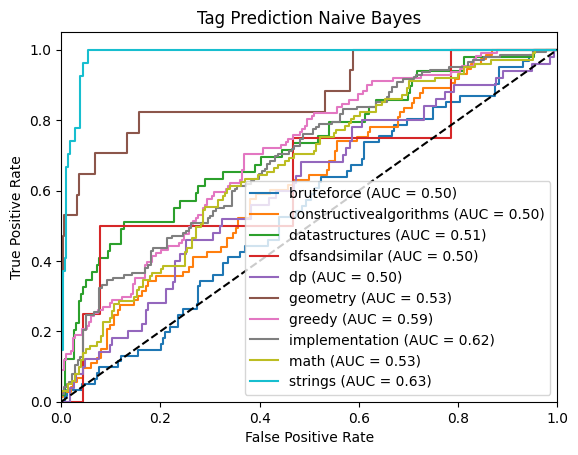

In [88]:
import matplotlib.pyplot as plt 

# Graficar la curva ROC para cada etiqueta
def plot_roc_auc(mlb,X_test,y_test,y_pred,classifier):
    n_classes = y_test.shape[1]

    plt.figure()

    probs=classifier.predict_proba(X_test)

    for i in range(n_classes):
        # Calcular el FPR y TPR para la etiqueta i
        fpr, tpr, _ = roc_curve(y_test[:, i], probs[:, i])
        
        # Graficar la curva ROC
        plt.plot(fpr, tpr, label=f'{mlb.classes_[i]} (AUC = {roc_auc_score(y_test[:, i], y_pred[:, i]):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal de referencia
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Tag Prediction Naive Bayes')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_auc(mlb,X_test,y_test,y_pred,classifier)